In this notebook, we will check out how to perform information extraction using NLP techniques in Python.

I recommend, going over [this article](https://www.analyticsvidhya.com/blog/2020/06/nlp-project-information-extraction/) to understand the concept in detail.

# What is Information Extraction?

Text data contains a lot of information but not all of it will be important to you. We might be looking for names of entities, others would want to extract specific relationships between those entities. Our intentions differ according to our requirements.

Imagine having to go through all the legal documents to find legal precedence to validate your current case. Or having to go through all the research papers to find relevant information to cure a disease. There are many more examples like resume harvesting, media analysis, email scanning, etc.

But just imagine having to manually go through all of the textual data and extracting the most relevant information. Clearly, it is an uphill battle and you might even end up skipping some important information.

For anyone trying to analyze textual data, the difficult task is not of finding the right documents, but of finding the right information from these documents. Understanding the relationship between entities, understanding how the events have unfolded, or just simply finding hidden gems of information, is clearly what anyone is looking for when they go through a piece of text.

Therefore, coming up with an automated way of extracting the information from textual data and presenting it in a structured manner will help us reap a lot of benefits and tremendously reduce the amount of time we have to spend time skimming through text documents. This is precisely what information extraction strives to achieve.


> `The task of Information Extraction (IE) involves extracting meaningful information from unstructured text data and presenting it in a structured format.`


Using information extraction, we can retrieve pre-defined information such as the name of a person, location of an organization, or identify a relation between entities, and save this information in a structured format such as a database.

This enables us to reap the benefits of powerful query tools like SQL for further analysis. Creating such structured data using information extraction will not only help us in analyzing the documents better but also help us in understanding the hidden relationships in the text.

# How does Information Extraction work?

Given the capricious nature of text data that changes depending on different authors and under different contexts, Information Extraction seems like a daunting task at hand. But it doesn't have to be so. 

We all know that sentences are made up of words belonging to various different Parts of Speech (POS). Their are eight different POS in the english language: noun, pronoun, verb, adjective , adverb, preposition, conjuction, and intersection. The POS determines how a specific word functions in meaning in a given sentence. For example take the word "right". In the sentence, "The boy was awarded with a chocolate for giving the right answer", "right" is used as an adjective. Whereas, in the sentence, "You have the right to say whatever you want", "right" is treated as a noun. This goes to show that POS tag of a word carries a lot of significance when it comes to understanding the meaning of a sentence. No doubt we can leverage it to extract meaningful information from our text.

In [1]:
# import spacy
import spacy

# load english language model
nlp = spacy.load('en_core_web_sm',disable=['ner','textcat'])

text = "This is a sample sentence."

# create spacy 
doc = nlp(text)

for token in doc:
    print(token.text,'->',token.pos_)

This -> DET
is -> AUX
a -> DET
sample -> NOUN
sentence -> NOUN
. -> PUNCT


We were easily able to determine the POS tags of all the words in the sentence. But how does it help in Information Extraction? 

Well, if we wanted to extract nouns from the sentences, we could take a look at POS tags of the words/tokens in the sentence, using the attribute **.pos_**, and extract them accordingly.

In [2]:
for token in doc:
    # check token pos
    if token.pos_=='NOUN':
        # print token
        print(token.text)

sample
sentence


It was that easy to extract words based on their POS tags. But sometimes extracting information purely based on the POS tags is not enough. Have a look at the sentence below:

In [3]:
text = "The children love cream biscuits"

# create spacy 
doc = nlp(text)

for token in doc:
    print(token.text,'->',token.pos_)

The -> DET
children -> NOUN
love -> VERB
cream -> NOUN
biscuits -> NOUN


If I wanted to extract the subject and the object from a sentence, I can’t do that based on their POS tags. For that, I need to look at how these words are related to each other. These are called **Dependencies**.

We can make use of [spaCy’s displacy](https://explosion.ai/demos/displacy) visualizer that displays the word dependencies in a graphical manner:

In [4]:
from spacy import displacy 
displacy.render(doc, style='dep',jupyter=True)

Pretty cool! This directed graph is known as a [dependency graph](https://www.analyticsvidhya.com/blog/2017/12/introduction-computational-linguistics-dependency-trees/). It represents the relations between different words of a sentence.

Each word is a **node** in the Dependency graph. The relationship between words is denoted by the edges. For example, “The” is a determiner here, “children” is the subject of the sentence, “biscuits” is the object of the sentence, and “cream” is a compound word that gives us more information about the object.

The arrows carry a lot of significance here:

- The **arrowhead** points to the words that are **dependent** on the word pointed by the **origin of the arrow**
- The former is referred to as the **child node** of the latter. For example, “children” is the child node of “love”
- The word which has no incoming arrow is called the **root node** of the sentence

Let’s see how we can extract the subject and the object from the sentence. Like we have an attribute for POS in SpaCy tokens, we similarly have an attribute for extracting the dependency of a token denoted by dep_:

In [4]:
for token in doc:
    # extract subject
    if (token.dep_=='nsubj'):
        print(token.text)
    # extract object
    elif (token.dep_=='dobj'):
        print(token.text)

children
biscuits


Voila! We have the subject and object of our sentence.

Using POS tags and Dependency tags, we can look for relationship between different entities in a sentence. For example, in the sentence "The **cat** perches **on** the **window sill**", we have two noun entities,"cat" and "window sill", related by the preposition "on". We can look for such relationships and much more to extract meaningful information from our text data.

*I suggest going through [this amazing blog](https://www.analyticsvidhya.com/blog/2019/09/introduction-information-extraction-python-spacy/) which explains Information Extraction with tons of examples.*

# Where Do We Go from Here?

We have briefly spoken about the theory regarding Information Extraction which I believe is important to understand before jumping into the crux of this article.

`“An ounce of practice is generally worth more than a ton of theory.” –E.F. Schumacher`

In the following sections, I am going to explore a text dataset and apply the information extraction technique to retrieve some important information, understand the structure of the sentences, and the relationship between entities.

So, without further ado, let’s get cracking on the code!

# Getting Familiar with the Text Dataset

The dataset we are going to be working with is the [United Nations General Debate Corpus](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/0TJX8Y). It contains speeches made by representatives of all the member countries from the year 1970 to 2018 at the General Debate of the annual session of United Nations General Assembly. 

But we will take a subset of this dataset and work with speeches made by India at these debates. This will allow us to stay on track and better understand the task at hand of understanding Information Extraction. This leaves us with 49 speeches made by India over the years, each speech ranging from anywhere between 2000 to 6000+ words.

Having said that, let’s have a look at our dataset:

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import re

In [11]:
# Folder path
folders = glob.glob('./UNGD/UNGDC 1970-2018/Converted sessions/Session*')

# Dataframe
df = pd.DataFrame(columns={'Country','Speech','Session','Year'})

# Read speeches by India
i = 0 
for file in folders:
    
    speech = glob.glob(file+'/IND*.txt')

    with open(speech[0],encoding='utf8') as f:
        # Speech
        df.loc[i,'Speech'] = f.read()
        # Year 
        df.loc[i,'Year'] = speech[0].split('_')[-1].split('.')[0]
        # Session
        df.loc[i,'Session'] = speech[0].split('_')[-2]
        # Country
        df.loc[i,'Country'] = speech[0].split('_')[0].split("\\")[-1]
        # Increment counter
        i += 1 
        
df.head()

,Speech,Year,Country,Session
0,"40.\t Mr. President, I offer you our congratul...",1970,IND,25
1,"38.\tMr. President, on behalf of the people of...",1971,IND,26
2,"Mr. President, I offer you on behalf of India ...",1972,IND,27
3,"﻿122.\tMr. President, I bring to you and to al...",1973,IND,28
4,"Mr. President, I have already had occasion to ...",1974,IND,29


I will print a snapshot of one of the speeches to give you a feel of what the data looks like.

In [13]:
df.loc[0,'Speech']

'40.\t Mr. President, I offer you our congratulations on your election as the President of the current session of the General Assembly. You represent Norway, a country which can take pride in its reputation as peaceful, just and progressive. Your personal qualifications and your family\'s dedication to international effort are well known. I should also like to express our appreciation of the services of your distinguished predecessor, Mrs. Angie Brooks Randolph. I would also repeat our admiration for U Thant, whose skill and dedication have won him our respect.\n41.\tToday is Mahatma Gandhi\'s one-hundred-first birthday, and we in India will take a fresh pledge to dedicate ourselves once again to the ideals for which the Mahatma lived and died, peace and nonviolence being the foremost among them. We may not fully succeed in living up to his ideals but we must continue to try.\n42.\tThere are many developments in India which give us satisfaction. Our people are expecting a better life t

Now let's start working with out dataset!

# Speech Text Pre-Processing

First, we need to clean our text data. When I went over a few speeches, I found each paragraph in the speech was numbered to distinctly identify it. There were obviously unwanted characters like newline character, a hyphen, salutations, and apostrophes, like in any other text dataset.

But another unique and unwanted information present were the references made in each speech to other documents. We obviously don’t want that either.

I have written a simple function to clean the speeches. **An important point here is that I haven’t used lemmatization or changed the words to lowercase as it has the potential to change the POS tag of the word.** We certainly don’t want to do that as you will see in the upcoming subsections.

In [14]:
# function to preprocess speech
def clean(text):
    
    # removing paragraph numbers
    text = re.sub('[0-9]+.\t','',str(text))
    # removing new line characters
    text = re.sub('\n ','',str(text))
    text = re.sub('\n',' ',str(text))
    # removing apostrophes
    text = re.sub("'s",'',str(text))
    # removing hyphens
    text = re.sub("-",' ',str(text))
    text = re.sub("— ",'',str(text))
    # removing quotation marks
    text = re.sub('\"','',str(text))
    # removing salutations
    text = re.sub("Mr\.",'Mr',str(text))
    text = re.sub("Mrs\.",'Mrs',str(text))
    # removing any reference to outside text
    text = re.sub("[\(\[].*?[\)\]]", "", str(text))
    
    return text

# preprocessing speeches
df['Speech_clean'] = df['Speech'].apply(clean)

Right, now that we have our minimally cleaned speeches, we can split it up into separate sentences.

# Split the Speech into Different Sentences

Spliting our speeches into separate sentences will allow us to extract information from each sentence and later we can combine it to get cummulative information from any specific year.

In [15]:
# split sentences
def sentences(text):
    # split sentences and questions
    text = re.split('[.?]', text)
    clean_sent = []
    for sent in text:
        clean_sent.append(sent)
    return clean_sent

# sentences
df['sent'] = df['Speech_clean'].apply(sentences)

In [16]:
df.head()

,Speech,Year,Country,Session,Speech_clean,sent
0,"40.\t Mr. President, I offer you our congratul...",1970,IND,25,"Mr President, I offer you our congratulations...","[ Mr President, I offer you our congratulation..."
1,"38.\tMr. President, on behalf of the people of...",1971,IND,26,"Mr President, on behalf of the people of India...","[Mr President, on behalf of the people of Indi..."
2,"Mr. President, I offer you on behalf of India ...",1972,IND,27,"Mr President, I offer you on behalf of India o...","[Mr President, I offer you on behalf of India ..."
3,"﻿122.\tMr. President, I bring to you and to al...",1973,IND,28,"﻿Mr President, I bring to you and to all our c...","[﻿Mr President, I bring to you and to all our ..."
4,"Mr. President, I have already had occasion to ...",1974,IND,29,"Mr President, I have already had occasion to c...","[Mr President, I have already had occasion to ..."


Finally, we can create a dataframe containing the sentences from different years:

In [18]:
# Create a dataframe containing sentences
df2 = pd.DataFrame(columns=['Sent','Year','Len'])

# List of sentences for new df
row_list = []

# for-loop to go over the df speeches
for i in range(len(df)):
    
    # for-loop to go over the sentences in the speech
    for sent in df.loc[i,'sent']:
        
        wordcount = len(sent.split())  # Word count
        year = df.loc[i,'Year']  # Year
        dict1 = {'Year':year,'Sent':sent,'Len':wordcount}  # Dictionary
        row_list.append(dict1)  # Append dictionary to list
    
# Create the new df
df2 = pd.DataFrame(row_list)

In [19]:
df2.head()

,Year,Sent,Len
0,1970,"Mr President, I offer you our congratulations...",21
1,1970,"You represent Norway, a country which can tak...",17
2,1970,Your personal qualifications and your family ...,13
3,1970,I should also like to express our appreciatio...,19
4,1970,I would also repeat our admiration for U Than...,18


In [20]:
df2.shape

(7150, 3)

After performing this operation, we end up with 7150 sentences. Going over them and extracting information manually will be a difficult task. That’s why we are looking at Information Extraction using NLP techniques!

# Information Extraction using SpaCy

Now to get to the crux of the discussion at hand, Information Extraction. We will be using the [Spacy](https://www.analyticsvidhya.com/blog/2020/03/spacy-tutorial-learn-natural-language-processing/) library for working with the text data. It has all the necessary tools that we can exploit for all the tasks we need for Information Extraction. 

Let me import the relevant SpaCy modules that we will require for the task ahead:

In [21]:
import spacy
from spacy.matcher import Matcher 

from spacy import displacy 
import visualise_spacy_tree
from IPython.display import Image, display

# load english language model
nlp = spacy.load('en_core_web_sm',disable=['ner','textcat'])

We will need the spaCy Matcher class to create a pattern to match phrases in the text. We’ll also require the displaCy module for visualizing the dependency graph of sentences.

The **visualise_spacy_tree** library will be needed for creating a tree-like structure out of the Dependency graph. This helps in visualizing the graph in a better way. Finally, IPython Image and display classes are required to output the tree.

But you don’t need to worry about these too much. It will become clear as you look at the code.

## Information Extraction #1 – Finding Mentions of Prime Minister in the Speech

When working on Information extraction task, it is important to manually go over a subset of the dataset to understand what the text is like and determine if anything catches your attention at first glance. 

When I first went over the speeches, I found out that many of them referred to what the Prime Minister had said, thought or achieved in the past. We know that a country is nothing without its leader. The destination a country ends up in is by and large the result of the able guidance of its leader. Therefore, I believe it is important to extract those sentences from the speeches that referred to Prime Ministers of India, and try and understand what their thinking and perspective was, and also try to unravel any common or differing beliefs over the years.

To achieve this task, I used [Spacy's Matcher class](https://spacy.io/api/matcher). It allows you to match a sequence of words based on certain patterns. For the current task, we know that whenever a Prime Minister is reffered to in the speech, it will be in one of the following ways:
* Prime Minister of [Country] ...
* Prime Minister [Name] ...

Using this general understanding one can come up with a pattern as follows:

pattern = [{'LOWER':'prime'},

           {'LOWER':'minister'},
              
           {'POS':'ADP','OP':'?'},
              
           {'POS':'PROPN'}]
        
Let me walk you through this pattern:     
* Here, each dictionary in the list is a unique word. 
* The first and second words match the keyword "Prime Minister" irrespective of whether it is in uppercase or not, which is why I have included the key "LOWER".
* The third keyword matches a word that is a preposition. What I am looking for here is the word "of". Now, as discussed before, it may or may not be present in the pattern, therefore, an additional key, "OP", is mentioned to point out just that.
* Finally, the last keyword in the phrase should be a proper noun. This is either be the name of the country or name of the prime minister.
* The matched keywords have to be in continuation otherwise the pattern will not match the phrase.

In [22]:
# Function to find sentences containing PMs of India
def find_names(text):
    
    names = []
    
    # Create a spacy doc
    doc = nlp(text)
    
    # Define the pattern
    pattern = [{'LOWER':'prime'},
              {'LOWER':'minister'},
              {'POS':'ADP','OP':'?'},
              {'POS':'PROPN'}]
                
    # Matcher class object 
    matcher = Matcher(nlp.vocab) 
    matcher.add("names", None, pattern) 

    matches = matcher(doc)

    # Finding patterns in the text
    for i in range(0,len(matches)):
        
        # match: id, start, end
        token = doc[matches[i][1]:matches[i][2]]
        # append token to list
        names.append(str(token))
    
    # Only keep sentences containing Indian PMs
    for name in names:
        if (name.split()[2] == 'of') and (name.split()[3] != "India"):
                names.remove(name)
            
    return names

# Apply function
df2['PM_Names'] = df2['Sent'].apply(find_names)

Here are some sample sentences from the year 1984 that matched our pattern:

In [24]:
# look at sentences for a specific year
for i in range(len(df2)):
    if df2.loc[i,'Year'] in ['1984']:
        if len(df2.loc[i,'PM_Names'])!=0:
            print('->',df2.loc[i,'Sent'],'\n')

->  In November 1948, the first Prime Minister of India, Pandit Jawaharlal Nehru, addressing the General Assembly' on behalf of newly independent India, stated that the Charter of the United Nations, in noble language, had laid down the principles and purposes of that great Organization, and he thought it would not be possible to improve upon that language 

->  As Prime Minister Indira Gandhi said in her address to the Seventh Conference of Heads of State or Government of Non Aligned Countries, held at New Delhi from 7 to 12 March 1983: Its significance is not to be measured by the number of divisions or the megatons of destructive power we command, but by the intensity with which we desire peace and freedom, development and international justice 

->  A major peace initiative in this regard was taken recently by the Prime Minister of India, Mrs Indira Gandhi, together with the Heads of State or Government of Argentina, Greece, Mexico, Sweden and the United Republic of Tanzania 

->  

In [25]:
count=0
for i in range(len(df2)):
    if len(df2.loc[i,'PM_Names'])!=0:
        count+=1
print(count)

58


Now, since only 58 sentences out of 7150 total sentences gave an output that matched our pattern, I have summarised the relevant information from these outputs here:

- PM Indira Gandhi and PM Jawaharlal Nehru believed in working together in unity and with the principles of the UN
- PM Indira Gandhi believed in striking a balance between global production and consumption. She set out policies dedicated to national reconstruction and the consolidation of a secular and pluralistic political system
- PM Indira Gandhi emphasized that India does not intervene in the internal affairs of other countries. However, this stand on foreign policy took a U-turn under PM Rajiv Gandhi when he signed an agreement with the Sri Lankan Prime Minister which brought peace to Sri Lanka
- Both PM Indira Gandhi and PM Rajiv Gandhi believed in the link between economic development and protection of the environment
- PM Rajiv Gandhi advocated for the disarmament of nuclear weapons, a belief that was upheld by India over the years
- Indian, under different PMs, has always extended a hand of peace towards Pakistan over the years
- PM Narendra Modi believes that economic empowerment and upliftment of any nation involves the empowerment of its women
- PM Narendra Modi has launched several schemes that will help India achieve its SGD goals

Using information extraction, we were able to isolate only a few sentences that we required that gave us maximum results.

## Information Extraction #2 – Finding Initiatives

The second interesting thing I noticed while going through the speeches is that there were a lot of initiatives, schemes, agreements, conferences, programs, etc. that were mentioned in the speeches. For example, ‘Paris agreement’, ‘Simla Agreement’, ‘Conference on Security Council’, ‘Conference of Non Aligned Countries’, ‘International Solar Alliance’, ‘Skill India initiative’, etc.

Extracting these would give us an idea about what are the priorities for India and whether there is a pattern as to why they are mentioned quite often in the speeches.

I am going to refer to all the schemes, initiatives, conferences, programmes, etc. keywords as initiatives.

To extract initiatives from the text, the first thing I am going to do is identify those sentences that talk about the initiatives. For that, I will use simple regex to select only those sentences that contain the keyword ‘initiative’, ‘scheme’, ‘agreement’, etc. This will reduce our search for the initiative pattern that we are looking for:

In [26]:
# Function to check if keyswords like 'programs','schemes', etc. present in sentences

def prog_sent(text):
    
    patterns = [r'\b(?i)'+'plan'+r'\b',
               r'\b(?i)'+'programme'+r'\b',
               r'\b(?i)'+'scheme'+r'\b',
               r'\b(?i)'+'campaign'+r'\b',
               r'\b(?i)'+'initiative'+r'\b',
               r'\b(?i)'+'conference'+r'\b',
               r'\b(?i)'+'agreement'+r'\b',
               r'\b(?i)'+'alliance'+r'\b']

    output = []
    flag = 0
    
    # Look for patterns in the text
    for pat in patterns:
        if re.search(pat, text) != None:
            flag = 1
            break
    return flag 

# Apply function
df2['Check_Schemes'] = df2['Sent'].apply(prog_sent)

C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Flags not at the start of the expression '\\b(?i)plan\\b'
C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Flags not at the start of the expression '\\b(?i)programme\\b'
C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Flags not at the start of the expression '\\b(?i)scheme\\b'
C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Flags not at the start of the expression '\\b(?i)campaign\\b'
C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Flags not at the start of the expression '\\b(?i)initiative\\b'
C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Flags not at the start of the expression '\\b(?i)conference\\b'
C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Flags not at 

In [27]:
# Sentences that contain the initiative words
count = 0
for i in range(len(df2)):
    if df2.loc[i,'Check_Schemes'] == 1:
        count+=1
print(count)

416


Now, you might be thinking that our task is done here as we have already identified the sentences. We can easily look these up and determine what is being talked about in these sentences. But, think about it, not all of these will contain the initiative name. Some of these might be generally talking about initiatives but no initiative name might be present in them.

Therefore, we need to come up with a better solution that extracts only those sentences that contain the initiative names. For that, I am going to use the spaCy Matcher, once again, to come up with a pattern that matches these initiatives.

As you might have noticed, the initiative name is a proper noun that starts with a determiner and ends with either ‘initiative’/’programme’/’agreement’ etc. words in the end. It also includes an occasional preposition in the middle. I also noticed that most of the initiative names were between two to five words long. Keeping this in mind, I came up with the following pattern to match the initiative names:

In [28]:
# To extract initiatives using pattern matching
def all_schemes(text,check):
    
    schemes = []
    
    doc = nlp(text)
    
    # Initiatives keywords
    prog_list = ['programme','scheme',
                 'initiative','campaign',
                 'agreement','conference',
                 'alliance','plan']
    
    # Define pattern to match initiatives names 
    pattern = [{'POS':'DET'},
               {'POS':'PROPN','DEP':'compound'},
               {'POS':'PROPN','DEP':'compound'},
               {'POS':'PROPN','OP':'?'},
               {'POS':'PROPN','OP':'?'},
               {'POS':'PROPN','OP':'?'},
               {'LOWER':{'IN':prog_list},'OP':'+'}
              ]
    
    if check == 0:
        # return blank list
        return schemes

    # Matcher class object 
    matcher = Matcher(nlp.vocab) 
    matcher.add("matching", None, pattern) 
    matches = matcher(doc)

    for i in range(0,len(matches)):
        
        # match: id, start, end
        start, end = matches[i][1], matches[i][2]
        
        if doc[start].pos_=='DET':
            start = start+1
        
        # matched string
        span = str(doc[start:end])
        
        if (len(schemes)!=0) and (schemes[-1] in span):
            schemes[-1] = span
        else:
            schemes.append(span)
        
    return schemes

# apply function
df2['Schemes1'] = df2.apply(lambda x:all_schemes(x.Sent,x.Check_Schemes),axis=1)

Lets see how many of the sentences contain an initiative name.

In [29]:
count = 0
for i in range(len(df2)):
    if len(df2.loc[i,'Schemes1'])!=0:
        count+=1
print(count)

62


62, not bad. Now lets have a look at a few of the outputs.

In [30]:
year = '2018'
for i in range(len(df2)):
    if df2.loc[i,'Year']==year:
        if len(df2.loc[i,'Schemes1'])!=0:
            print('->',df2.loc[i,'Year'],',',df2.loc[i,'Schemes1'],':')
            print(df2.loc[i,'Sent'])

-> 2018 , ['International Solar Alliance'] :
 Prime Minister Modi, together with the Prime Minister of France, launched the International Solar Alliance


But one thing I must point out here is that there were a lot more initiatives in the speeches that did not match our pattern. For example, in the year 2018, there were other initiatives too like “MUDRA”, ”Ujjwala”, ”Paris Agreement”, etc. So is there a better way to extract them?

Remember how we looked at dependencies at the beginning of the article? Well, we are going to use those to make some rules to match the initiative name. But before making a rule, you need to understand how a sentence is structured, only then can you come up with a general rule to extract relevant information.

To understand the structure of the sentence I am going to print the dependency graph of a sample example but in a tree fashion which gives a better intuition of the structure. Have a look below:

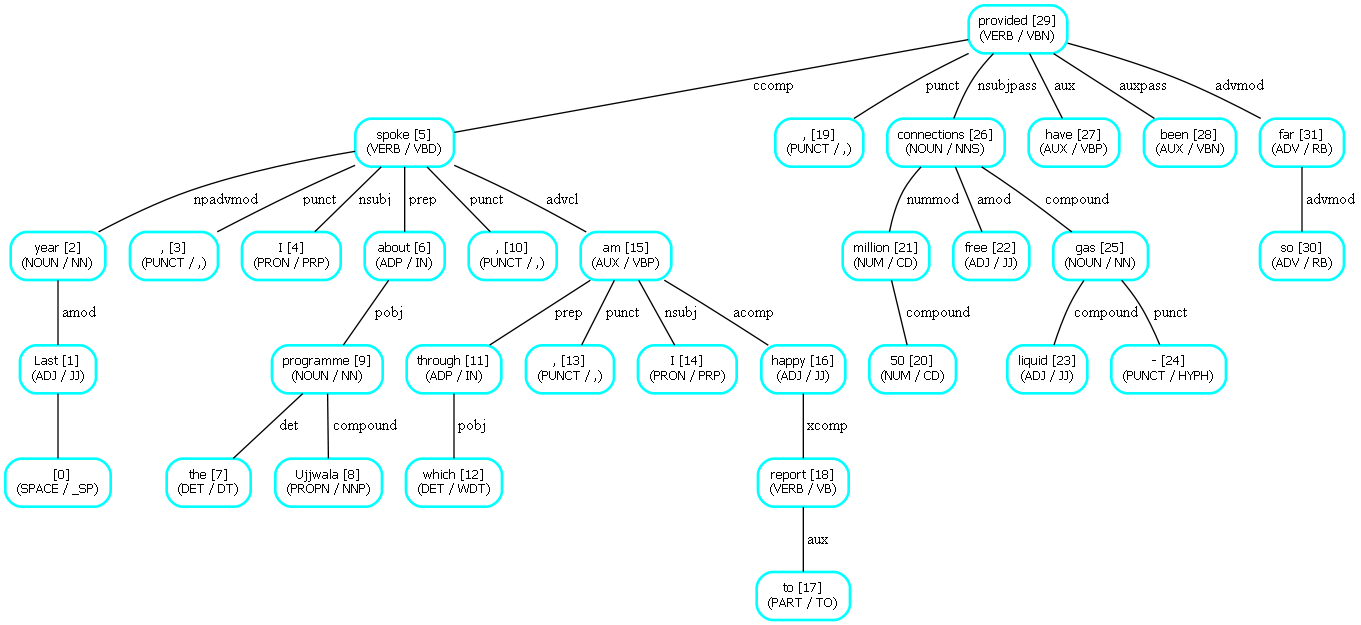

In [31]:
# Printing dependency tree
doc = nlp(' Last year, I spoke about the Ujjwala programme , through which, I am happy to report, 50 million free liquid-gas connections have been provided so far')
png = visualise_spacy_tree.create_png(doc)
display(Image(png))

See how 'Ujjwala' is a child node of 'programme'. Have a look at another example.

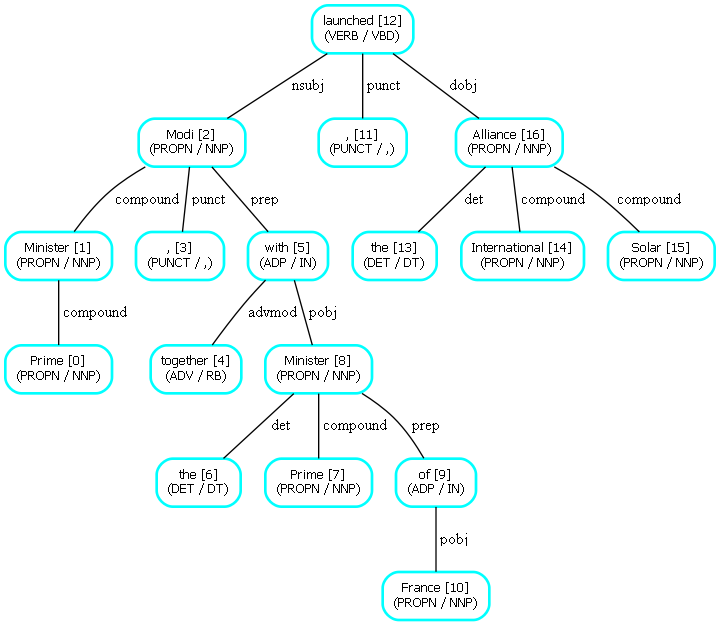

In [32]:
doc = nlp('Prime Minister Modi, together with the Prime Minister of France, launched the International Solar Alliance')
png = visualise_spacy_tree.create_png(doc)
display(Image(png))

Notice how the 'International Solar Alliance' is structured.

You must got the idea by now that the initiative names are usually children of nodes that containing words like 'initiative','programme',etc. Based on this knowledge we can develop our own rule. 

The rule I am suggesting is pretty simple. Let me walk you through it.
* I am going to look for tokens in sentences that contain my initiative keywords. 
* Then I am going to look at its subtree (or words dependent on it) using *token.subtree* and extract only those nodes/words that are proper nouns, since they are most likely going to contain the name of the initiative.

In [33]:
# rule to extract initiative name
def sent_subtree(text):
    
    # pattern match for schemes or initiatives
    patterns = [r'\b(?i)'+'plan'+r'\b',
           r'\b(?i)'+'programme'+r'\b',
           r'\b(?i)'+'scheme'+r'\b',
           r'\b(?i)'+'campaign'+r'\b',
           r'\b(?i)'+'initiative'+r'\b',
           r'\b(?i)'+'conference'+r'\b',
           r'\b(?i)'+'agreement'+r'\b',
           r'\b(?i)'+'alliance'+r'\b']
    
    schemes = []
    doc = nlp(text)
    flag = 0
    # if no initiative present in sentence
    for pat in patterns:
        
        if re.search(pat, text) != None:
            flag = 1
            break
    
    if flag == 0:
        return schemes

    # iterating over sentence tokens
    for token in doc:

        for pat in patterns:
                
            # if we get a pattern match
            if re.search(pat, token.text) != None:

                word = ''
                # iterating over token subtree
                for node in token.subtree:
                    # only extract the proper nouns
                    if (node.pos_ == 'PROPN'):
                        word += node.text+' '

                if len(word)!=0:
                    schemes.append(word)

    return schemes      

# derive initiatives
df2['Schemes2'] = df2['Sent'].apply(sent_subtree)

Now let's see if we did any better than the last approach.

In [34]:
count = 0
for i in range(len(df2)):
    if len(df2.loc[i,'Schemes2'])!=0:
        count+=1
print(count)

273


Wow, we matched 273 entries! That is a significant improvement over the previous result. Lets go over some of the sample outputs.

In [35]:
year = '2018'
for i in range(len(df2)):
    if df2.loc[i,'Year']==year:
        if len(df2.loc[i,'Schemes2'])!=0:
            print('->',df2.loc[i,'Year'],',',df2.loc[i,'Schemes2'],':')
            print(df2.loc[i,'Sent'])

-> 2018 , ['National Health Protection Scheme '] :
 The Ayushman Bharat Yojana, or National Health Protection Scheme, is the answer to that prayer
-> 2018 , ['Micro Units Development Refinance Agency '] :
 Two extremely effective programmes have also been initiated to increase the skill levels of those waiting to be employed through the National Skill Development Corporation and the Micro Units Development and Refinance Agency  programme, which seeks to turn the poor into entrepreneurs
-> 2018 , ['MUDRA '] :
 The most significant aspect of the MUDRA scheme is the fact that 76 per cent of its beneficiaries are women
-> 2018 , ['Ujjwala '] :
 Last year, I spoke about the Ujjwala programme , through which, I am happy to report, 50 million free liquid gas connections have been provided so far
-> 2018 , ['India '] :
 Another such initiative is the maternity benefit programme, in which women in India are provided with 26 weeks of paid leave to care for their newborns
-> 2018 , ['Paris Agreem

Out of 7000+ sentences, we were able to zero down to just 282 sentences that talked about initiatives. I looped over these outputs and below is how I would summarise the output:

* There are a lot of different international initiatives or schemes that India has mentioned in its speeches. This goes to show that India has been an active member of the international community working towards building a better future by solving problems through these intiavtives. 

* Another point to highlight here is that the initiatives mentioned in the initial years have been more focused on those that concern the international coomunity. However, during recent times, especially after 2014, a lot of domestic initiatives have been mentioned in the speeches like 'Ayushman Bharat', 'Pradhan Mantri Jan Dhan Yojana', etc. This shows a shift in how the country percevies its role in the community. By mentioning a lot of domestic initiatives, India has started to put more of the domestic work in front of the international community to witness and, probably, even follow in their footsteps. 

Having said that, the results were definitely not perfect. There were instances when unwanted words were also got extracted with the initiative names. But the output derived by making our own rules was definitely better than the ones derived by using Spacy's pattern matcher. This goes to show the felixibility that one can achieve with making your own rules.

## Finding Patterns in the Speeches

So far, we extracted only that information that met our analytical eye when we skimmed over the data. But is there any other information hidden in our dataset? Surely there is and we are going to explore that by making our own rules using the dependency of the words, as we did in the previous section.

But before that, I want to point out two things.

First, when we are trying to understand the structure of the speech, we cannot look at the entire speech, that would take an eternity, and time is of the essence here. What we are going to do instead is look at random sentences from the dataset and then, based on their structure, try to come up with general rules to extract information.

But how do we test the validity of these rules? That’s where my second point comes in! Not all of the rules that we come up with will yield satisfactory results. So, to sift out the irrelevant rules, we can look at the percentage of sentences that matched our rule out of all sentences. This will give us a fair idea about how well the rule is performing, and whether, in fact, there is any such general structure in the corpus!

Another very important point that needs to be highlighted here is that any corpus is bound to contain long complex sentences. Working with these sentences to try and understand their structure will be a very difficult task. Therefore, we are going to look at smaller sentences. This will give us the opportunity to better understand their structure. So what’s the magic number? Let’s first look at how the sentence length varies in our corpus.

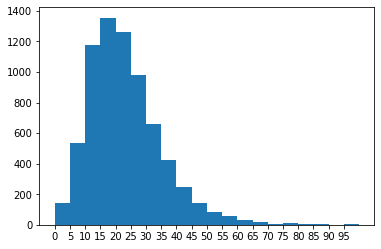

In [36]:
plt.hist(df2['Len'],bins=20,range=[0,100])
plt.xticks(np.arange(0,100,5));

Looking at the histogram, we can see that most of the sentences range from 15-20 words. So I am going to work with sentences that have no more than 15 words.

In [37]:
row_list = []
# df2 contains all sentences from all speeches
for i in range(len(df2)):
    sent = df2.loc[i,'Sent']
    
    if (',' not in sent) and (len(sent.split()) <= 15):
        
        year = df2.loc[i,'Year']
        length = len(sent.split())
        
        dict1 = {'Year':year,'Sent':sent,'Len':length}
        row_list.append(dict1)
        
# df with shorter sentences
df3 = pd.DataFrame(columns=['Year','Sent',"Len"])
df3 = pd.DataFrame(row_list)

In [38]:
df3.head()

,Year,Sent,Len
0,1970,Your personal qualifications and your family ...,13
1,1970,There are many developments in India which gi...,10
2,1970,Our people are expecting a better life throug...,11
3,1970,We have had a sizable increase in agricultura...,11
4,1970,Our trade is also showing signs of improvement,8


Now, lets come up with a function that will generate random sentences from this dataframe. 

In [39]:
from random import randint
def rand_sent(df):
    
    index = randint(0, len(df))
    print('Index = ',index)
    doc = nlp(df.loc[index,'Sent'][1:])
    displacy.render(doc, style='dep',jupyter=True)
    
    return index

In [40]:
rand_sent(df3)

Index =  480


480

Finally, let's make a fucntion to evaluate the result of our rule.

In [41]:
# function to check output percentage for a rule
def output_per(df,out_col):
    
    result = 0
    
    for out in df[out_col]:
        if len(out)!=0:
            result+=1
    
    per = result/len(df)
    per *= 100
    
    return per

Right, let's get down to the business of making some rules!

## Information Extraction #3 – Rule on Noun-Verb-Noun Phrases

When you look at a sentence, it generally contains a **subject(noun), action(verb) and an object(noun)**. Rest of the words are just there to give us additional information about the entities. Therefore, we can leverage this basic structure to extract the main bits of information from the sentence. Take for example the following sentence:

In [43]:
# To download dependency graphs to local folder
from pathlib import Path

text = df3.loc[9,'Sent'][1:]

doc = nlp(text)
img = displacy.render(doc, style='dep',jupyter=True)
img

# To save to folder
# output_path = Path("./img1.svg")
# output_path.open("w", encoding="utf-8").write(img)

What will be extracted is "countries face threats", which should give us a fair idea about what the sentence is trying to say.

So lets look at how this rule fairs what we run it against the short sentences that are working with.

In [44]:
# Function for rule 1: noun(subject), verb, noun(object)
def rule1(text):
    
    doc = nlp(text)
    
    sent = []
    
    for token in doc:
        
        # If the token is a verb
        if (token.pos_=='VERB'):
            
            phrase =''
            
            # Only extract noun or pronoun subjects
            for sub_tok in token.lefts:
                
                if (sub_tok.dep_ in ['nsubj','nsubjpass']) and (sub_tok.pos_ in ['NOUN','PROPN','PRON']):
                    
                    # Add subject to the phrase
                    phrase += sub_tok.text

                    # Save the root of the word in phrase
                    phrase += ' '+token.lemma_ 

                    # Check for noun or pronoun direct objects
                    for sub_tok in token.rights:
                        
                        # Save the object in the phrase
                        if (sub_tok.dep_ in ['dobj']) and (sub_tok.pos_ in ['NOUN','PROPN']):
                                    
                            phrase += ' '+sub_tok.text
                            sent.append(phrase)
            
    return sent

In [45]:
# Create a df containing sentence and its output for rule 1
row_list = []

for i in range(len(df3)):
    
    sent = df3.loc[i,'Sent']
    year = df3.loc[i,'Year']
    output = rule1(sent)
    dict1 = {'Year':year,'Sent':sent,'Output':output}
    row_list.append(dict1)
    
df_rule1 = pd.DataFrame(row_list)

# Rule 1 achieves 20% result on simple sentences
output_per(df_rule1,'Output')

22.71892222902633

We are getting more than 20% pattern match for our rule, we can check it for all the sentences in the corpus.

In [46]:
# Create a df containing sentence and its output for rule 1
row_list = []

# df2 contains all the sentences from all the speeches
for i in range(len(df2)):
    
    sent = df2.loc[i,'Sent']
    year = df2.loc[i,'Year']
    output = rule1(sent)
    dict1 = {'Year':year,'Sent':sent,'Output':output}
    row_list.append(dict1)
    
df_rule1_all = pd.DataFrame(row_list)

# Check rule1 output on complete speeches
output_per(df_rule1_all,'Output')

31.300699300699304

We are getting more than a 30% match for our rules, which means 2226 out of 7150 sentences matched this pattern. Let’s form a new dataframe containing only those sentences that have an output and then segregate the verb from the nouns:

In [47]:
# selecting non-empty output rows
df_show = pd.DataFrame(columns=df_rule1_all.columns)

for row in range(len(df_rule1_all)):
    
    if len(df_rule1_all.loc[row,'Output'])!=0:
        df_show = df_show.append(df_rule1_all.loc[row,:])

# reset the index
df_show.reset_index(inplace=True)
df_show.drop('index',axis=1,inplace=True)        

In [48]:
df_rule1_all.shape, df_show.shape

((7150, 3), (2238, 3))

In [49]:
# separate subject, verb and object

verb_dict = dict()
dis_dict = dict()
dis_list = []

# iterating over all the sentences
for i in range(len(df_show)):
    
    # sentence containing the output
    sentence = df_show.loc[i,'Sent']
    # year of the sentence
    year = df_show.loc[i,'Year']
    # output of the sentence
    output = df_show.loc[i,'Output']
    
    # iterating over all the outputs from the sentence
    for sent in output:
        
        # separate subject, verb and object
        n1 = sent.split()[:1]
        v = sent.split()[1]
        n2 = sent.split()[2:]
        
        # append to list, along with the sentence
        dis_dict = {'Sent':sentence,'Year':year,'Noun1':n1,'Verb':v,'Noun2':n2}
        dis_list.append(dis_dict)
        
        # counting the number of sentences containing the verb
        verb = sent.split()[1]
        if verb in verb_dict:
            verb_dict[verb]+=1
        else:
            verb_dict[verb]=1

df_sep = pd.DataFrame(dis_list)

We can seperate the verb from the subject noun and object noun. This will allows us to better analyse the result.

In [50]:
df_sep.head()

,Sent,Year,Noun1,Verb,Noun2
0,"Mr President, I offer you our congratulations...",1970,[I],offer,[congratulations]
1,"You represent Norway, a country which can tak...",1970,[You],represent,[Norway]
2,I would also repeat our admiration for U Than...,1970,[I],repeat,[admiration]
3,I would also repeat our admiration for U Than...,1970,[skill],win,[respect]
4,Today is Mahatma Gandhi one hundred first bir...,1970,[we],take,[pledge]


Lets take a look at the top occuring verbs used in the sentences.

In [51]:
sort = sorted(verb_dict.items(), key = lambda d:(d[1],d[0]), reverse=True)
# top 10 most used verbs in sentence
sort[:10]

[('take', 103),
 ('give', 63),
 ('welcome', 60),
 ('provide', 56),
 ('support', 55),
 ('make', 53),
 ('need', 40),
 ('see', 39),
 ('face', 38),
 ('require', 31)]

Now we can look at specific verbs to see what kind of information is prsent. For example 'welcome' and 'support' could tell us what India encourages. And verbs like 'face' could maybe tell use what kind of problems we face in the real world.

In [52]:
# support verb
df_sep[df_sep['Verb']=='support']

,Sent,Year,Noun1,Verb,Noun2
28,We would support any steps which may be sugge...,1970,[We],support,[steps]
38,As regards the conference on the law of the s...,1970,[delegation],support,[viewpoints]
190,My delegation would support the taking of fur...,1972,[delegation],support,[taking]
220,We shall support all measures to intensify an...,1973,[We],support,[measures]
239,We support the initiative of the Food and Agr...,1973,[We],support,[initiative]
272,We support the early convening of a world dis...,1974,[We],support,[convening]
338,India has consistently supported efforts in t...,1976,[India],support,[efforts]
523,My delegation fully supports the adoption by ...,1979,[delegation],support,[adoption]
611,We should certainly support every effort for ...,1980,[We],support,[effort]
790,We support the valiant efforts of the Palesti...,1983,[We],support,[efforts]


In [53]:
# face
df_sep[df_sep['Verb']=='face']

,Sent,Year,Noun1,Verb,Noun2
16,The developing countries particularly face in...,1970,[countries],face,[threats]
17,They also face impediments in their economic ...,1970,[They],face,[impediments]
81,"We are facing grave social, economic and poli...",1971,[We],face,[consequences]
130,The world today is facing a major economic cr...,1971,[world],face,[crisis]
309,We are now in the middle of the Second United...,1975,[majority],face,[patterns]
346,Developing countries now face the dilemma of ...,1976,[countries],face,[dilemma]
391,"The authority, credibility and prestige of th...",1977,[authority],face,[challenge]
396,While in southern Africa we face colonialism ...,1977,[we],face,[colonialism]
630,"Like most other nations, we too faced the con...",1980,[we],face,[conflict]
651,All countries in our region face similar econ...,1981,[countries],face,[problems]


By looking at the output, we can try to make out what is the context of the sentence. For example, we can see that India supports ‘efforts’, ‘viewpoints’, ‘initiatives’, ‘struggles’, ‘desires, ‘aspirations’, etc. While India believes that the world faces ‘threat’, ‘conflicts’, ‘colonialism’, ‘pandemics’, etc.

We can select sentences to explore in-depth by looking at the output. This will definitely save us a lot of time than just going over the entire text.

## Information Extraction #4 – Rule on Adjective Noun Structure

In the previous rule that we made, we extracted the noun subjects and objects, but the information did not feel complete. This is because many nouns have an adjective or a word with a compound dependency that augments the meaning of a noun. Extracting these along with the noun will give us better information about the subject and the object.

Have a look at the sample sentence below.

In [55]:
text = 'Our people are expecting a better life.'
print(text)
doc = nlp(text)
img = displacy.render(doc, style='dep',jupyter=True)
img

#output_path = Path("./img2.svg")
#output_path.open("w", encoding="utf-8").write(img)

Our people are expecting a better life.


What we are looking to achieve here is: "people","expecting" and "better life".

The code for this rule is simple, but let me walk you through how it works:
* We look for tokens that have a Noun POS tag and have subject or object dependency
* Then we look at the child nodes of these tokens and append it to the phrase only if it modifies the noun

In [56]:
# function for rule 2
def rule2(text):
    
    doc = nlp(text)

    pat = []
    
    # iterate over tokens
    for token in doc:
        phrase = ''
        # if the word is a subject noun or an object noun
        if (token.pos_ == 'NOUN')\
            and (token.dep_ in ['dobj','pobj','nsubj','nsubjpass']):
            
            # iterate over the children nodes
            for subtoken in token.children:
                # if word is an adjective or has a compound dependency
                if (subtoken.pos_ == 'ADJ') or (subtoken.dep_ == 'compound'):
                    phrase += subtoken.text + ' '
                    
            if len(phrase)!=0:
                phrase += token.text
             
        if  len(phrase)!=0:
            pat.append(phrase)
        
    
    return pat

In [57]:
# Create a df containing sentence and its output for rule 2
row_list = []

for i in range(len(df3)):
    
    sent = df3.loc[i,'Sent']
    year = df3.loc[i,'Year']
    # Rule 2
    output = rule2(sent)
    
    dict1 = {'Year':year,'Sent':sent,'Output':output}
    row_list.append(dict1)

df_rule2 = pd.DataFrame(row_list)

In [59]:
df_rule2.head()

,Year,Sent,Output
0,1970,Your personal qualifications and your family ...,"[personal qualifications, international effort]"
1,1970,There are many developments in India which gi...,[]
2,1970,Our people are expecting a better life throug...,"[better life, development plans]"
3,1970,We have had a sizable increase in agricultura...,"[sizable increase, agricultural production]"
4,1970,Our trade is also showing signs of improvement,[]


In [58]:
# Rule 2 output
output_per(df_rule2,'Output')

51.92896509491733

51% of the short sentences match this rule. We can try now check it on the entire corpus.

In [60]:
# create a df containing sentence and its output for rule 2
row_list = []

# df2 contains all the sentences from all the speeches
for i in range(len(df2)):
    
    sent = df2.loc[i,'Sent']
    year = df2.loc[i,'Year']
    output = rule2(sent)
    dict1 = {'Year':year,'Sent':sent,'Output':output}
    row_list.append(dict1)
    
df_rule2_all = pd.DataFrame(row_list)

# check rule output on complete speeches
output_per(df_rule2_all,'Output')

76.5034965034965

In [61]:
df_rule2_all.head(10)

,Year,Sent,Output
0,1970,"Mr President, I offer you our congratulations...",[current session]
1,1970,"You represent Norway, a country which can tak...",[]
2,1970,Your personal qualifications and your family ...,"[personal qualifications, international effort]"
3,1970,I should also like to express our appreciatio...,[distinguished predecessor]
4,1970,I would also repeat our admiration for U Than...,[]
5,1970,Today is Mahatma Gandhi one hundred first bir...,[fresh pledge]
6,1970,We may not fully succeed in living up to his ...,[]
7,1970,There are many developments in India which gi...,[]
8,1970,Our people are expecting a better life throug...,"[better life, development plans]"
9,1970,We have had a sizable increase in agricultura...,"[sizable increase, agricultural production]"


In [66]:
df_rule2_all.shape,df_show2.shape

((7150, 3), (5470, 3))

Out of 7150, 5470 sentences matched our pattern rule.

In [65]:
# Selecting non-empty outputs
df_show2 = pd.DataFrame(columns=df_rule2_all.columns)

for row in range(len(df_rule2_all)):
    
    if len(df_rule2_all.loc[row,'Output'])!=0:
        df_show2 = df_show2.append(df_rule2_all.loc[row,:])

# Reset the index
df_show2.reset_index(inplace=True)
df_show2.drop('index',axis=1,inplace=True)        

In [67]:
df_show2.head(10)

,Year,Sent,Output
0,1970,"Mr President, I offer you our congratulations...",[current session]
1,1970,Your personal qualifications and your family ...,"[personal qualifications, international effort]"
2,1970,I should also like to express our appreciatio...,[distinguished predecessor]
3,1970,Today is Mahatma Gandhi one hundred first bir...,[fresh pledge]
4,1970,Our people are expecting a better life throug...,"[better life, development plans]"
5,1970,We have had a sizable increase in agricultura...,"[sizable increase, agricultural production]"
6,1970,India has once again demonstrated its faith i...,[full democracy]
7,1970,Alongside this there is a growing desire of t...,"[common man, national wealth]"
8,1970,twenty two days ago a great conference ended ...,[great conference]
9,1970,The final declarations and resolution s of th...,"[final declarations, Nations documents]"


Now we can combine this rule along with the rule that we created previously. This will give us a better perspective of what information in present in a sentence.

In [62]:
def rule2_mod(text,index):
    
    doc = nlp(text)

    phrase = ''
    
    for token in doc:
        
        if token.i == index:
            
            for subtoken in token.children:
                if (subtoken.pos_ == 'ADJ'):
                    phrase += ' '+subtoken.text
            break
    
    return phrase

In [63]:
# rule 1 modified function
def rule1_mod(text):
    
    doc = nlp(text)
    
    sent = []
    
    for token in doc:
        # root word
        if (token.pos_=='VERB'):
            
            phrase =''
            
            # only extract noun or pronoun subjects
            for sub_tok in token.lefts:
                
                if (sub_tok.dep_ in ['nsubj','nsubjpass']) and (sub_tok.pos_ in ['NOUN','PROPN','PRON']):
                        
                    adj = rule2_mod(text,sub_tok.i)
                    
                    phrase += adj + ' ' + sub_tok.text

                    # save the root word of the word
                    phrase += ' '+token.lemma_ 

                    # check for noun or pronoun direct objects
                    for sub_tok in token.rights:
                        
                        if (sub_tok.dep_ in ['dobj']) and (sub_tok.pos_ in ['NOUN','PROPN']):
                             
                            adj = rule2_mod(text,sub_tok.i)
                            
                            phrase += adj+' '+sub_tok.text
                            sent.append(phrase)
            
    return sent

In [64]:
# create a df containing sentence and its output for modified rule 1
row_list = []

# df2 contains all the sentences from all the speeches
for i in range(len(df2)):
    
    sent = df2.loc[i,'Sent']
    year = df2.loc[i,'Year']
    output = rule1_mod(sent)
    dict1 = {'Year':year,'Sent':sent,'Output':output}
    row_list.append(dict1)
    
df_rule1_mod_all = pd.DataFrame(row_list)
# check rule1 output on complete speeches
output_per(df_rule1_mod_all,'Output')

31.300699300699304

In [65]:
df_rule1_mod_all.head(20)

,Year,Sent,Output
0,1970,"Mr President, I offer you our congratulations...",[ I offer congratulations]
1,1970,"You represent Norway, a country which can tak...",[ You represent Norway]
2,1970,Your personal qualifications and your family ...,[]
3,1970,I should also like to express our appreciatio...,[]
4,1970,I would also repeat our admiration for U Than...,"[ I repeat admiration, skill win respect]"
5,1970,Today is Mahatma Gandhi one hundred first bir...,[ we take fresh pledge]
6,1970,We may not fully succeed in living up to his ...,[]
7,1970,There are many developments in India which gi...,[]
8,1970,Our people are expecting a better life throug...,[ people expect better life]
9,1970,We have had a sizable increase in agricultura...,[ We have sizable increase]


In the previous rule that we made, we extracted the noun subjects and objects, but the information did not feel complete. This is because many nouns have an adjective or a word with a compound dependency that augments the meaning of a noun. Extracting these along with the noun will give us better information about the subject and the object.

## Information Extraction #5 – Rule on Prepositions

Thank god for preposistions. They tell us where or when something is in relationship with something else. For example, *The people **of** India believe **in** the priciples **of** United Nations.*. Clearly extarcting phrases inclusing prepositions will give us a lot of information from the sentence. This is exactly what we are going to achieve with this rule.

Let's try to understand how this rule works by going over it on a sample sentece - "India has once again shown faith in democracy."

* We iterate over all the tokens looking for prepositions. For example *in* in this sentence.
* On encountering a preposition, we check if it has a head word that is a noun. For example the word *faith* in this sentence.
* Then we look at the child tokens of the preposition token falling on its right side. For example, the word *democracy*.

This should finally extract the phrase *faith in democracy* from the sentence. Have a look at the dependency graph of the sentence below.

In [67]:
text = "India has once again shown faith in democracy."
print(text)
doc = nlp(text)
img = displacy.render(doc, style='dep',jupyter=True)
img

#output_path = Path("./img3.svg")
# output_path.open("w", encoding="utf-8").write(img)
# displacy.render(doc, style='dep',jupyter=True)

India has once again shown faith in democracy.


Now lets apply this rule to our short sentences.

In [68]:
# rule 3 function
def rule3(text):
    
    doc = nlp(text)
    
    sent = []
    
    for token in doc:

        # look for prepositions
        if token.pos_=='ADP':

            phrase = ''
            
            # if its head word is a noun
            if token.head.pos_=='NOUN':
                
                # append noun and preposition to phrase
                phrase += token.head.text
                phrase += ' '+token.text

                # check the nodes to the right of the preposition
                for right_tok in token.rights:
                    # append if it is a noun or proper noun
                    if (right_tok.pos_ in ['NOUN','PROPN']):
                        phrase += ' '+right_tok.text
                
                if len(phrase)>2:
                    sent.append(phrase)
                
    return sent

In [69]:
# create a df containing sentence and its output for rule 4
row_list = []

for i in range(len(df3)):
    
    sent = df3.loc[i,'Sent']
    year = df3.loc[i,'Year']
    
    # Rule 3
    output = rule3(sent)
    
    dict1 = {'Year':year,'Sent':sent,'Output':output}
    row_list.append(dict1)

df_rule3 = pd.DataFrame(row_list)
# Rule 3 achieves 40% result
output_per(df_rule3,'Output')

48.928352725045926

About 48% of the sentences follow this rule.

In [70]:
df_rule3.head(10)

,Year,Sent,Output
0,1970,Your personal qualifications and your family ...,[dedication to effort]
1,1970,There are many developments in India which gi...,[developments in India]
2,1970,Our people are expecting a better life throug...,[]
3,1970,We have had a sizable increase in agricultura...,[increase in production]
4,1970,Our trade is also showing signs of improvement,[signs of improvement]
5,1970,India has once again demonstrated its faith i...,[faith in democracy]
6,1970,I would urge that everyone read them,[]
7,1970,The Conference at Lusaka highlighted several ...,[]
8,1970,This situation requires attention from the wo...,[attention from community]
9,1970,The developing countries particularly face in...,[]


We can test this pattern on the entire corpus since we have good amount of sentences matching the rule.

In [71]:
# create a df containing sentence and its output for rule 1
row_list = []

# df2 contains all the sentences from all the speeches
for i in range(len(df2)):
    
    sent = df2.loc[i,'Sent']
    year = df2.loc[i,'Year']
    output = rule3(sent)  # Output
    dict1 = {'Year':year,'Sent':sent,'Output':output}
    row_list.append(dict1)
    
df_rule3_all = pd.DataFrame(row_list)
# check rule1 output on complete speeches
output_per(df_rule3_all,'Output')

74.7132867132867

In [72]:
df_rule3_all.head(10)

,Year,Sent,Output
0,1970,"Mr President, I offer you our congratulations...","[congratulations on election, session of Assem..."
1,1970,"You represent Norway, a country which can tak...",[]
2,1970,Your personal qualifications and your family ...,[dedication to effort]
3,1970,I should also like to express our appreciatio...,"[appreciation of services, services of predece..."
4,1970,I would also repeat our admiration for U Than...,[admiration for Thant]
5,1970,Today is Mahatma Gandhi one hundred first bir...,[]
6,1970,We may not fully succeed in living up to his ...,[]
7,1970,There are many developments in India which gi...,[developments in India]
8,1970,Our people are expecting a better life throug...,[]
9,1970,We have had a sizable increase in agricultura...,[increase in production]


Show only those sentences that have outputs

In [73]:
# select non-empty outputs
df_show3 = pd.DataFrame(columns=df_rule3_all.columns)

for row in range(len(df_rule3_all)):
    
    if len(df_rule3_all.loc[row,'Output'])!=0:
        df_show3 = df_show3.append(df_rule3_all.loc[row,:])

# reset the index
df_show3.reset_index(inplace=True)
df_show3.drop('index',axis=1,inplace=True)        

In [74]:
df_rule3_all.shape, df_show3.shape

((7150, 3), (5342, 3))

In [75]:
# separate noun, preposition and noun

prep_dict = dict()
dis_dict = dict()
dis_list = []

# iterating over all the sentences
for i in range(len(df_show3)):
    
    # sentence containing the output
    sentence = df_show3.loc[i,'Sent']
    # year of the sentence
    year = df_show3.loc[i,'Year']
    # output of the sentence
    output = df_show3.loc[i,'Output']
    
    # iterating over all the outputs from the sentence
    for sent in output:
        
        # separate subject, verb and object
        n1 = sent.split()[0]
        p = sent.split()[1]
        n2 = sent.split()[2:]
        
        # append to list, along with the sentence
        dis_dict = {'Sent':sentence,'Year':year,'Noun1':n1,'Preposition':p,'Noun2':n2}
        dis_list.append(dis_dict)
        
        # counting the number of sentences containing the verb
        prep = sent.split()[1]
        if prep in prep_dict:
            prep_dict[prep]+=1
        else:
            prep_dict[prep]=1

df_sep3= pd.DataFrame(dis_list)

The following dataframe shows the result of the rule on the entire corpus. 

In [76]:
df_sep3.head(10)

,Sent,Year,Noun1,Preposition,Noun2
0,"Mr President, I offer you our congratulations...",1970,congratulations,on,[election]
1,"Mr President, I offer you our congratulations...",1970,session,of,[Assembly]
2,Your personal qualifications and your family ...,1970,dedication,to,[effort]
3,I should also like to express our appreciatio...,1970,appreciation,of,[services]
4,I should also like to express our appreciatio...,1970,services,of,[predecessor]
5,I would also repeat our admiration for U Than...,1970,admiration,for,[Thant]
6,There are many developments in India which gi...,1970,developments,in,[India]
7,We have had a sizable increase in agricultura...,1970,increase,in,[production]
8,Our trade is also showing signs of improvement,1970,signs,of,[improvement]
9,India has once again demonstrated its faith i...,1970,faith,in,[democracy]


We can look at the topmost occuring prepositions in the entire corpus.

In [77]:
sort = sorted(prep_dict.items(), key = lambda d:(d[1],d[0]), reverse=True)
sort[:10]

[('of', 7110),
 ('in', 1427),
 ('for', 887),
 ('to', 611),
 ('on', 469),
 ('with', 284),
 ('between', 164),
 ('by', 139),
 ('from', 116),
 ('against', 91)]

We look at certain prepositions to explore the sentences in detail. For example the preposition 'against'. It can give us information about what India does not support.

In [78]:
# 'against'
df_sep3[df_sep3['Preposition']=='against']

,Sent,Year,Noun1,Preposition,Noun2
238,The determination of the international commun...,1970,check,against,[measures]
500,There is a popular revolt against these actions,1971,revolt,against,[actions]
896,We must ensure that our solidarity in the com...,1972,struggle,against,[discrimination]
1682,"The expansion of the Diego Garcia base, again...",1975,expansion,against,[wishes]
1721,There is no clearer case for intervention by ...,1975,action,against,[Africa]
1861,"My Prime Minister, Mrs Indira Gandhi, stated ...",1976,shelter,against,[pressures]
2028,The initiative taken by the Federal Republic ...,1976,convention,against,[taking]
2280,"In the meantime, India reaffirms its support ...",1977,liberation,against,[odds]
2281,If world opinion continues to be wilfully def...,1977,sanctions,against,[regime]
2379,"Sixthly, there should be a world wide movemen...",1977,movement,against,[extravagance]


Skimming over the nouns, some important phrases like:

* efforts against proliferation
* fight against terrorism, action against terrorism, war against terrorism
* dsicrimination against women
* war against poverty
* struggle against colonialism

... and so on. This should give us a fair idea about which sentences we want to explore in detail. For exmaple, *efforts against proliferation* talks about efforts towards nuclear disarmament. Or the sentence on *struggle against colonialism* talks about the historical links between India and Africa borne out of their common struggle against colonialism.

In [79]:
df_sep3.loc[11272,'Sent']

'  This year, 25 years after Prime Minister Rajiv Gandhi  put forward a comprehensive action plan for a nuclear  weapon free and non violent world order, we must  strengthen efforts against nuclear proliferation and  pursue time bound, universal, non discriminatory,  phased and verifiable nuclear disarmament'

In [80]:
df_sep3.loc[11513,'Sent']

' Africa is a region with which we have historical bonds, a solidarity born out of a common struggle against colonialism and a belief in a future of shared prosperity'

In [81]:
df_sep3.loc[11618,'Sent']

' We need to forget our prejudices and join hands to draw up an effective strategy against terror'

In [82]:
df_sep3.loc[11859,'Sent']

' It has become something of a habit for Pakistan to throw the dust of deceit and deception up against India in order to provide some thin cover for its own guilt'

As you can see, prepositions give us an important relationship between two nouns. And with a little domain knowledge we can easily seive through the vast data and determine what India supports or does not support and much more.

But at some time the output seems a bit incomplete. For example, in the sentence *efforts against proliferation*, what kind of a *proliferation* are we talking about? Certainly we need to include the modifiers attached to the nouns in the phrase, like we did in rule 2. This would definitely increase the comprehensibility of the extracted phrase.

This rule can be easily modified to include the new change. I have created a new function to extract the noun modifiers for nouns that we extracted from rule 3.

In [83]:
# rule 0
def rule0(text, index):
    
    doc = nlp(text)
        
    token = doc[index]
    
    entity = ''
    
    for sub_tok in token.children:
        if (sub_tok.dep_ in ['compound','amod']):# and (sub_tok.pos_ in ['NOUN','PROPN']):
            entity += sub_tok.text+' '
    
    entity += token.text

    return entity

All we have to do is call this function whenever we encounter a noun in our phrase.

In [84]:
# rule 3 function
def rule3_mod(text):
    
    doc = nlp(text)
    
    sent = []
    
    for token in doc:

        if token.pos_=='ADP':

            phrase = ''
            if token.head.pos_=='NOUN':
                
                # appended rule
                append = rule0(text, token.head.i)
                if len(append)!=0:
                    phrase += append
                else:  
                    phrase += token.head.text
                phrase += ' '+token.text

                for right_tok in token.rights:
                    if (right_tok.pos_ in ['NOUN','PROPN']):
                        
                        right_phrase = ''
                        # appended rule
                        append = rule0(text, right_tok.i)
                        if len(append)!=0:
                            right_phrase += ' '+append
                        else:
                            right_phrase += ' '+right_tok.text
                            
                        phrase += right_phrase
                
                if len(phrase)>2:
                    sent.append(phrase)
                

    return sent

In [85]:
# create a df containing sentence and its output for rule 3
row_list = []

# df2 contains all the sentences from all the speeches
for i in range(len(df_show3)):
    
    sent = df_show3.loc[i,'Sent']
    year = df_show3.loc[i,'Year']
    output = rule3_mod(sent)
    dict1 = {'Year':year,'Sent':sent,'Output':output}
    row_list.append(dict1)
    
df_rule3_mod = pd.DataFrame(row_list)

In [86]:
df_rule3_mod

,Year,Sent,Output
0,1970,"Mr President, I offer you our congratulations...","[congratulations on election, current session ..."
1,1970,Your personal qualifications and your family ...,[family dedication to international effort]
2,1970,I should also like to express our appreciatio...,"[appreciation of services, services of disting..."
3,1970,I would also repeat our admiration for U Than...,[admiration for U Thant]
4,1970,There are many developments in India which gi...,[many developments in India]
5,1970,We have had a sizable increase in agricultura...,[sizable increase in agricultural production]
6,1970,Our trade is also showing signs of improvement,[signs of improvement]
7,1970,India has once again demonstrated its faith i...,[faith in full fledged democracy]
8,1970,Alongside this there is a growing desire of t...,"[growing desire of common man, distribution of..."
9,1970,twenty two days ago a great conference ended ...,"[days from, signing of Charter]"


This definitely has more information than before. For example, 'impediments in economic development' instead of 'impediments in development' and 'greater transgressor of human rights' rather than 'transgressor of rights'.

Once again combining rules has given us more power and flexibility to explore only those sentences in detail that have a meaningful extracted phrase.

In [87]:
# separate noun, preposition and noun

prep_dict = dict()
dis_dict = dict()
dis_list = []

# iterating over all the sentences
for i in range(len(df_rule3_mod)):
    
    # sentence containing the output
    sentence = df_rule3_mod.loc[i,'Sent']
    # year of the sentence
    year = df_rule3_mod.loc[i,'Year']
    # output of the sentence
    output = df_rule3_mod.loc[i,'Output']
    
    # iterating over all the outputs from the sentence
    for sent in output:
        
        # separate subject, verb and object
        n1 = sent[0]
        p = sent[1]
        n2 = sent[2:]
        
        # append to list, along with the sentence
        dis_dict = {'Sent':sentence,'Year':year,'Noun1':n1,'Preposition':p,'Noun2':n2}
        dis_list.append(dis_dict)
        
        # counting the number of sentences containing the verb
        prep = sent[1]
        if prep in prep_dict:
            prep_dict[verb]+=1
        else:
            prep_dict[verb]=1

df_sep3_mod = pd.DataFrame(dis_list)

In [89]:
df_sep3

,Sent,Year,Noun1,Preposition,Noun2
0,"Mr President, I offer you our congratulations...",1970,congratulations,on,[election]
1,"Mr President, I offer you our congratulations...",1970,session,of,[Assembly]
2,Your personal qualifications and your family ...,1970,dedication,to,[effort]
3,I should also like to express our appreciatio...,1970,appreciation,of,[services]
4,I should also like to express our appreciatio...,1970,services,of,[predecessor]
5,I would also repeat our admiration for U Than...,1970,admiration,for,[Thant]
6,There are many developments in India which gi...,1970,developments,in,[India]
7,We have had a sizable increase in agricultura...,1970,increase,in,[production]
8,Our trade is also showing signs of improvement,1970,signs,of,[improvement]
9,India has once again demonstrated its faith i...,1970,faith,in,[democracy]


# End Notes

Information extraction is by no means an easy NLP task to perform. You need to spend time with the data to better understand its structure and what it has to offer.

In this article, we used theoretical knowledge and put it to practical use. We worked with a text dataset and tried to extract the information using traditional information extraction techniques.

We looked for key phrases and relationships in the text data to try and extract the information from the text. This type of approach requires a combination of computer and human effort to extract relevant information.